In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, shapiro, mannwhitneyu
import warnings
import seaborn as sns
from scipy import stats

warnings.filterwarnings("ignore")

C:\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
C:\Users\Настя\AppData\Local\Temp\ipykernel_9680\1941158301.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv(r"data.csv")
df

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


In [3]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [4]:
# Generating the data
control = df.loc[df["VARIANT_NAME"] == "control"]
test = df.loc[df["VARIANT_NAME"] == "variant"]

In [5]:
control

,USER_ID,VARIANT_NAME,REVENUE
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
6,2849,control,0.0
7,9168,control,0.0
...,...,...,...
9988,428,control,0.0
9994,3129,control,0.0
9995,1981,control,0.0
9998,7741,control,0.0


In [6]:
test

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.00
4,6174,variant,0.00
5,2380,variant,0.00
8,6205,variant,0.00
13,2529,variant,2.15
...,...,...,...
9991,8864,variant,0.00
9992,9303,variant,0.00
9993,2400,variant,0.00
9996,502,variant,0.00


# Step 1 -  Formulating Hypotheses

Null Hypothesis (H0): μ1 = μ2 (There is no statistically significant difference in terms of revenue between the Control and Variant Groups)

Alternative Hypothesis (H1): μ1 ≠ μ2 (There is a statistically significant difference between the Control and Variant Groups in terms of revenue)

# Step 2 - Checking assumptions

When performing an A/B test, there are several assumptions that should be checked to ensure the validity of the statistical analysis.

### Normal Distribution  (Shapiro-Wilk Test).

H0: The assumption of normal distribution is satisfied.

H1: The assumption of normal distribution is not satisfied.

$p < 0.05$: H0 REJECTED

$p > 0.05$: H0 NOT REJECTED

### Homogeneity of Variance.

H0: Variances of the groups are homogeneous.

H1: Variances of the groups are not homogeneous.

$p < 0.05$: H0 REJECTED

$p > 0.05$: H0 NOT REJECTED

In [7]:
t, p_value = shapiro(control["REVENUE"])
print('Test Stat=%.3f, P-value=%.3f'%(t, p_value))

t, p_value = shapiro(test["REVENUE"])
print('Test Stat=%.3f, P-value=%.3f'%(t, p_value))

Test Stat=0.018, P-value=0.000
Test Stat=0.027, P-value=0.000


P-Value is less than 0.05 so we reject H0 hyposesis, indicating that the data does not follow a normal distribution. 
As a result, there is no need to assess the homogeneity of variances. We can proceed directly to non-parametric statistical analysis, specifically the Mann-Whitney test.

# Step 3 - Performing Mann-Whitney non-parametric test 

In [8]:
test_stat,pvalue = mannwhitneyu(control["REVENUE"],
                                test['REVENUE'])
print('Test stat = %.4f, P-value=%.4f'%(test_stat,pvalue))

Test stat = 12521564.0000, P-value=0.4783


Result: P-valie > 0.05 that means that we accept the null hypothesis. In this context, we conclude that there is no statistically significant difference in terms of revenue between the Control and Variant Groups.

# Bootstraping method

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap. Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics.

In [9]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

Samples for all users

In [10]:
control = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'control', 'REVENUE'].values, 10000)
variant = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'].values, 10000)

Only paying users

In [11]:
control_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'].values, 10000)
variant_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'].values, 10000)

In [12]:
control_mean = np.mean(control, axis = 1)
variant_mean = np.mean(variant, axis = 1)

Text(0.5, 1.0, 'Sample mean distribution for all users')

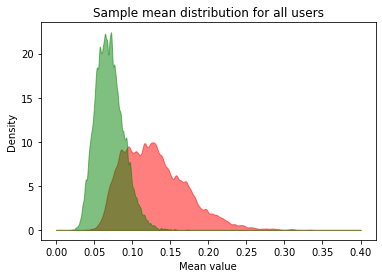

In [13]:
#Plotting the distribution of means in the ab test groups
kde_cm = stats.gaussian_kde(control_mean, bw_method = 0.05)
kde_vm = stats.gaussian_kde(variant_mean, bw_method = 0.05)
xx = np.linspace(0, 0.4, 1000)
plt.fill_between(xx, y1 = kde_cm(xx), color = 'red', alpha = 0.5)
plt.fill_between(xx, y1 = kde_vm(xx), color = 'green', alpha = 0.5)
plt.ylabel("Density")
plt.xlabel("Mean value")
plt.title('Sample mean distribution for all users')

There are differences between the mean values, but since their confidence intervals might overlap, we need to study the distribution of these differences to make clear conclusions.
We will proceed by developing a function to visualize this mean difference distribution and to construct confidence intervals for it. This approach will help us better understand and quantify the distinctions between the group measurements.

In [14]:
control_mean_paid = np.mean(control_paid, axis = 1)
variant_mean_paid = np.mean(variant_paid, axis = 1)

kde_cm = stats.gaussian_kde(control_mean_paid, bw_method = 0.05)
kde_vm = stats.gaussian_kde(variant_mean_paid, bw_method = 0.05)
xx = np.linspace(0, 18.0, 1000)
plt.fill_between(xx, y1 = kde_cm(xx), color = 'red', alpha = 0.5)
plt.fill_between(xx, y1 = kde_vm(xx), color = 'green', alpha = 0.5)
plt.ylabel("Density")
plt.xlabel("Mean value")
plt.title('Sample mean distribution for paying users')

In [15]:
cl = stat_intervals(variant_mean - control_mean, alpha=0.05)
kde_cm = stats.gaussian_kde(control_mean, bw_method = 0.05)

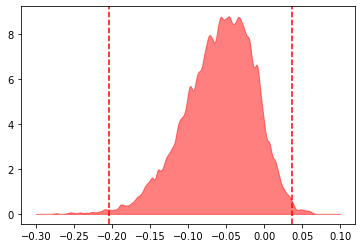

In [16]:
cl = stat_intervals(variant_mean - control_mean, alpha=0.01)
kde_d = stats.gaussian_kde(variant_mean - control_mean, bw_method = 0.05)
xx = np.linspace(-0.3, 0.1, 1000)
plt.fill_between(xx, y1 = kde_d(xx), color = 'red', alpha = 0.5)
plt.axvline(cl[0], ls = '--', color = 'red')
plt.axvline(cl[1],  ls = '--', color = 'red')